# Credit Card Lead Prediction
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 

**Current problem** the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.

**Data Dictionary**
<table>
<tbody>
<tr> <th> Variable </th> <th> Definition </th> </tr>

<tr> <td> ID </td> <td> Unique Identifier for a row</td> </tr>

<tr> <td> Gender </td> <td> Gender of the Customer </td> </tr>

<tr> <td>Age </td> <td> Age of the Customer (in Years) </td> </tr>

<tr> <td>Region_Code </td> <td> Code of the Region for the customers </td> </tr>

<tr> <td> Occupation </td> <td> Occupation Type for the customer </td> </tr>

<tr> <td> Channel_Code </td> <td> Acquisition Channel Code for the Customer  (Encoded) </td> </tr>

<tr> <td> Vintage </td> <td> Vintage for the Customer (In Months)</td> </tr>

<tr> <td> Credit_Product </td> <td> If the Customer has any active credit product (Home loan, Personal loan, Credit Card etc.) </td> </tr>

<tr> <td> Avg_Account_Balance </td> <td> Average Account Balance for the Customer in last 12 Months  </td> </tr>

<tr> <td> Is_Active </td> <td> If the Customer is Active in last 3 Months </td> </tr>

<tr> <td> Is_Lead(Target) </td> <td> If the Customer is interested for the Credit Card <br> 0 : Customer is not interested <br> 1 : Customer is interested </td> </tr>


</tbody>
</table>


## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Data

In [2]:
df_ads = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_s3TEQDk.csv")
df_ads.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## Data Wrangling

In [4]:
print("number of rows and columns of the data")
df_ads.shape

number of rows and columns of the data


(245725, 11)

In [5]:
df_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


- **There are only 4 integer columns**
- **Credit product is a categorical value and has null values**

### Treatment of missing data

In [5]:
df_ads['Credit_Product'].unique()

array(['No', nan, 'Yes'], dtype=object)

In [6]:
print("Count of No", len(df_ads[df_ads.Credit_Product == 'No']))
print("Count of Yes", len(df_ads[df_ads.Credit_Product == 'Yes']))

Count of No 144357
Count of Yes 72043


**Missing data in Credit product is to be treated with mode value which in this case is No**

In [7]:
df_ads_v1 = df_ads.fillna("No")
df_ads_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       245725 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


## Exploratory Data Analysis

### Univariate Analysis


In [8]:
df_ads_v1.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


#### Numerical variables

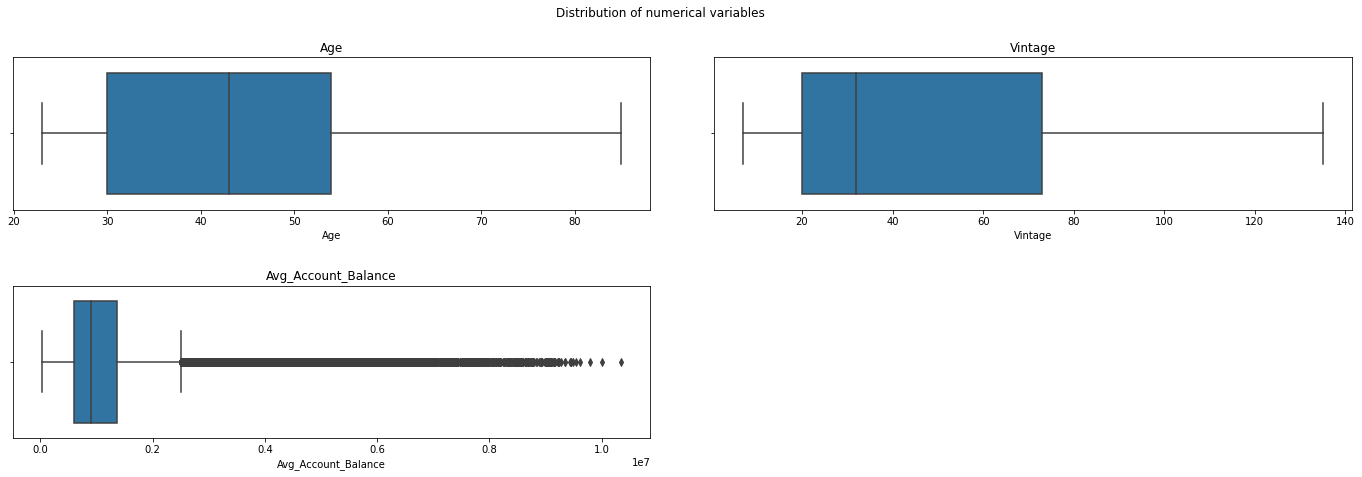

In [9]:
plt.figure(figsize=[24,7])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.5)

plt.subplot(2, 2, 1)
sns.boxplot(df_ads_v1.Age)
plt.title("Age")
plt.plot()
plt.subplot(2, 2, 2)
sns.boxplot(df_ads_v1.Vintage)
plt.title("Vintage")
plt.plot()
plt.subplot(2, 2, 3)
sns.boxplot(df_ads_v1.Avg_Account_Balance)
plt.title("Avg_Account_Balance")
plt.plot()

plt.suptitle("Distribution of numerical variables")
plt.show()

#### Categorical variables

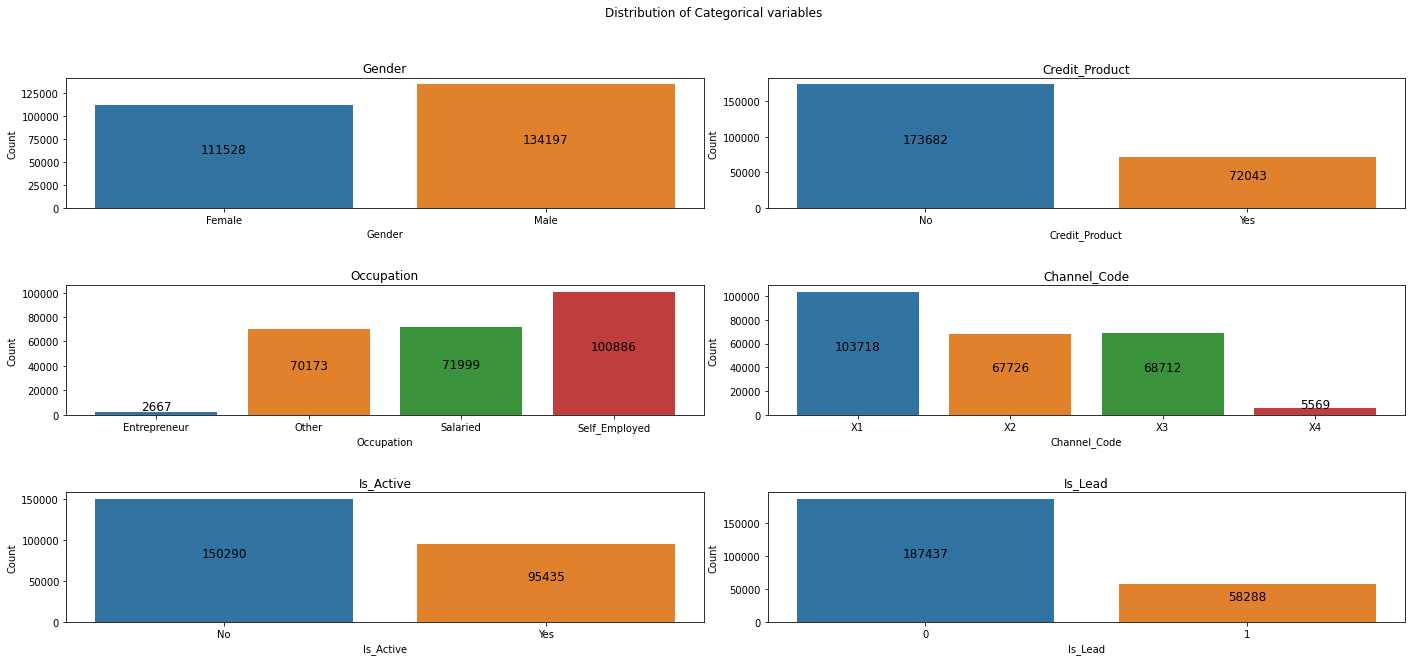

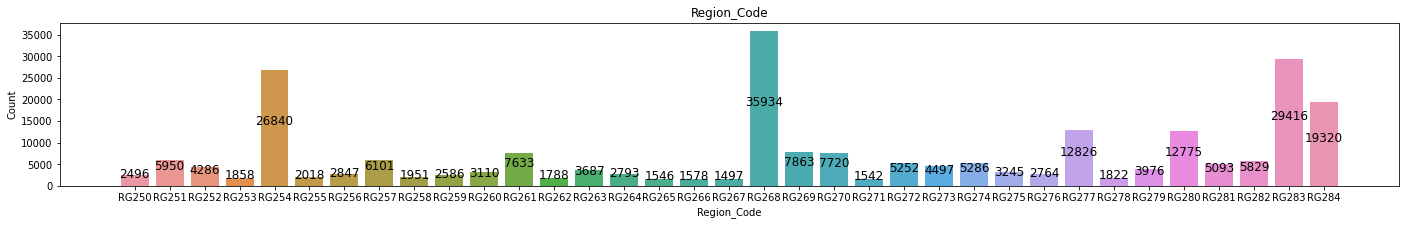

In [10]:
plt.figure(figsize=[24,10])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.6)


plt.subplot(3, 2, 1)
df_temp = df_ads_v1.groupby(df_ads_v1['Gender'], as_index = False).count()
sns.barplot(df_temp.Gender, df_temp.ID)
plt.ylabel("Count")
plt.title("Gender")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.subplot(3, 2, 2)
df_temp = df_ads_v1.groupby(df_ads_v1['Credit_Product'], as_index = False).count()
sns.barplot(df_temp.Credit_Product, df_temp.ID)
plt.ylabel("Count")
plt.title("Credit_Product")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.subplot(3, 2, 3)
df_temp = df_ads_v1.groupby(df_ads_v1['Occupation'], as_index = False).count()
sns.barplot(df_temp.Occupation, df_temp.ID)
plt.ylabel("Count")
plt.title("Occupation")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.subplot(3, 2, 4)
df_temp = df_ads_v1.groupby(df_ads_v1['Channel_Code'], as_index = False).count()
sns.barplot(df_temp.Channel_Code, df_temp.ID)
plt.ylabel("Count")
plt.title("Channel_Code")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.subplot(3, 2, 5)
df_temp = df_ads_v1.groupby(df_ads_v1['Is_Active'], as_index = False).count()
sns.barplot(df_temp.Is_Active, df_temp.ID)
plt.ylabel("Count")
plt.title("Is_Active")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.subplot(3, 2, 6)
df_temp = df_ads_v1.groupby(df_ads_v1['Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Is_Lead, df_temp.ID)
plt.ylabel("Count")
plt.title("Is_Lead")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()

plt.suptitle("Distribution of Categorical variables")
plt.show()

plt.figure(figsize=[24,3])
df_temp = df_ads_v1.groupby(df_ads_v1['Region_Code'], as_index = False).count()
sns.barplot(df_temp.Region_Code, df_temp.ID)
plt.ylabel("Count")
plt.title("Region_Code")
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*p.get_height() , '%d' % int(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()
plt.show()

### Bivariate Analysis

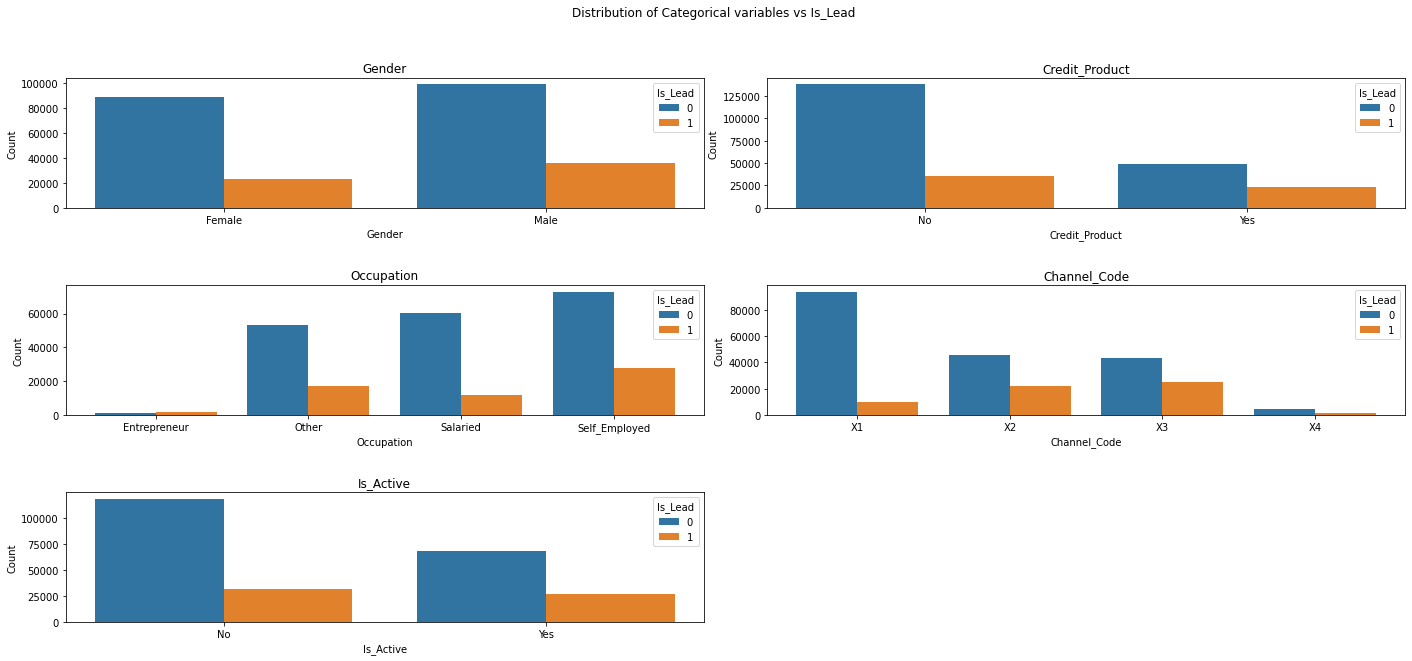

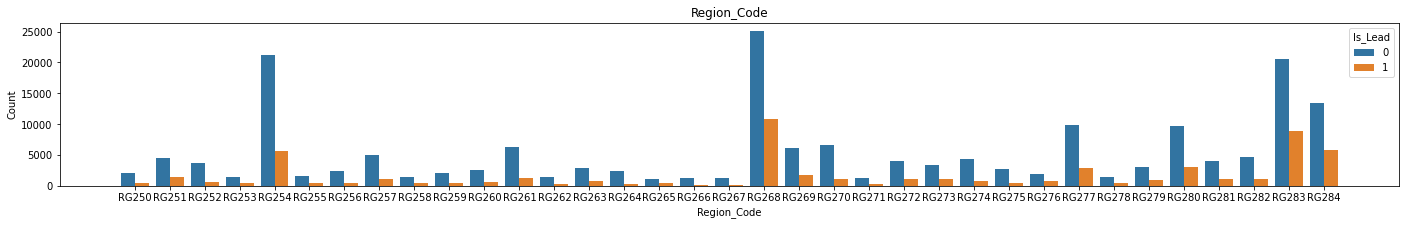

In [11]:
plt.figure(figsize=[24,10])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.6)


plt.subplot(3, 2, 1)
df_temp = df_ads_v1.groupby(['Gender','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Gender, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Gender")
plt.plot()

plt.subplot(3, 2, 2)
df_temp = df_ads_v1.groupby(['Credit_Product','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Credit_Product, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Credit_Product")
plt.plot()

plt.subplot(3, 2, 3)
df_temp = df_ads_v1.groupby(['Occupation','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Occupation, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Occupation")
plt.plot()

plt.subplot(3, 2, 4)
df_temp = df_ads_v1.groupby(['Channel_Code','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Channel_Code, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Channel_Code")
plt.plot()

plt.subplot(3, 2, 5)
df_temp = df_ads_v1.groupby(['Is_Active','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Is_Active, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Is_Active")
plt.plot()


plt.suptitle("Distribution of Categorical variables vs Is_Lead")
plt.show()

plt.figure(figsize=[24,3])
df_temp = df_ads_v1.groupby(['Region_Code','Is_Lead'], as_index = False).count()
sns.barplot(df_temp.Region_Code, df_temp.ID, hue = df_temp['Is_Lead'])
plt.ylabel("Count")
plt.title("Region_Code")
plt.plot()
plt.show()

## Model Training

### Baseline Random forest model with missing value

In [9]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)        
y = df_ads['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
## Training the model
baseline_w_missing = RandomForestClassifier(random_state=0, n_jobs =-1)
baseline_w_missing.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
## AUC_ROC_SCORE
y_pred_baseline_w_missing = baseline_w_missing.predict_proba(X_test)
auc_baseline_w_missing = roc_auc_score(y_test, y_pred_baseline_w_missing[:,1])
print(auc_baseline_w_missing)
confusion_matrix(y_test, baseline_w_missing.predict(X_test))

0.8515625845427243


array([[35061,  2459],
       [ 4949,  6676]])

### Baseline Random forest model without missing value

In [12]:
##Splitting the data into train and test for training of the model
X = df_ads_v1[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads_v1['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
## Training the model
baseline_wo_missing = RandomForestClassifier(random_state=0)
baseline_wo_missing.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [14]:
## AUC_ROC_SCORE
y_pred_baseline_wo_missing = baseline_wo_missing.predict_proba(X_test)
auc_baseline_wo_missing = roc_auc_score(y_test, y_pred_baseline_wo_missing[:,1])
print(auc_baseline_wo_missing)
confusion_matrix(y_test, baseline_wo_missing.predict(X_test))

0.7517195497168535


array([[34348,  3172],
       [ 7920,  3705]])

### Tuned Random forest model with missing value

In [107]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X['Occupation_Entrepreneur_mod'] = X['Occupation'].replace({'Entrepreneur': 1, 'Salaried': 0, 'Self_Employed': 1, 'Other': 0})
X = pd.get_dummies(X)    
del X['Occupation_Self_Employed']        
y = df_ads['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [108]:
## Training the model
Tuned_RF = RandomForestClassifier(max_depth=12, n_estimators=150,  random_state=0, n_jobs =-1)
Tuned_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [109]:
## AUC_ROC_SCORE
y_pred_tune_RF = Tuned_RF.predict_proba(X_test)
auc_tune_RF = roc_auc_score(y_test, y_pred_tune_RF[:,1])
print(auc_tune_RF)
confusion_matrix(y_test,  Tuned_RF.predict(X_test))
#0.8693156148804984

0.8686972384617532


array([[17876,   768],
       [ 2771,  3158]])

### Tuned Random forest model without missing value

In [24]:
##Splitting the data into train and test for training of the model
X = df_ads_v1[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
## Training the model
Tuned_RF_wo_missing = RandomForestClassifier(max_depth=10, n_estimators=150,  random_state=0, n_jobs =-1)
Tuned_RF_wo_missing.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [26]:
## AUC_ROC_SCORE
y_pred_tune_RF_wo_missng = Tuned_RF_wo_missing.predict_proba(X_test)
auc_tune_RF_wo_missing = roc_auc_score(y_test, y_pred_tune_RF_wo_missng[:,1])
print(auc_tune_RF_wo_missing)
confusion_matrix(y_test,  Tuned_RF_wo_missing.predict(X_test))

0.779846453217782


array([[37277,   243],
       [10169,  1456]])

### Random forest with treatment of imbalance data by using SMOTE

In [29]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print("Total rows", len(X_train))
counter = Counter(y_train)
print(counter)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Oversample treated")
print("New Total number of rows", len(X_train))
counter = Counter(y_train)
print(counter)

Total rows 208866
Counter({0: 159307, 1: 49559})
Oversample treated
New Total number of rows 318614
Counter({1: 159307, 0: 159307})


In [30]:
## Training the model
RF_smote = RandomForestClassifier(max_depth=10, n_estimators=150,  random_state=0, n_jobs =-1)
RF_smote.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [31]:
## AUC_ROC_SCORE
y_pred_smote = RF_smote.predict_proba(X_test)
auc_smote = roc_auc_score(y_test, y_pred_smote[:,1])
print(auc_smote)
confusion_matrix(y_test, RF_smote.predict(X_test))

0.866273195122868


array([[25363,  2767],
       [ 2879,  5850]])

### XGboost tuned

In [32]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
## Training the model
XGB_tuned = XGBClassifier(max_depth  = 11,  learning_rate = 0.3,  random_state=0, n_jobs=-1, min_child_weight=2, n_estimators=150)
XGB_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=11,
              min_child_weight=2, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
## AUC_ROC_SCORE
y_pred_xgb = XGB_tuned.predict_proba(X_test)
auc_xgb = roc_auc_score(y_test, y_pred_xgb[:,1])
print(auc_xgb)
confusion_matrix(y_test, XGB_tuned.predict(X_test))

0.8605598963706811


array([[35424,  2096],
       [ 4990,  6635]])

### XGboost with treatment of imbalance data by using SMOTE

In [48]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Total rows", len(X_train))
counter = Counter(y_train)
print(counter)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

print("Oversample treated")
print("New Total number of rows", len(X_train))
counter = Counter(y_train)
print(counter)

Total rows 196580
Counter({0: 149917, 1: 46663})
Oversample treated
New Total number of rows 299834
Counter({0: 149917, 1: 149917})


In [60]:
## Training the model
XGB_smote = XGBClassifier(max_depth  = 11,  learning_rate = 0.3, base_score=0.4,  random_state=0, n_jobs=-1, n_estimators=150)
XGB_smote.fit(X_train, y_train)

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [61]:
## AUC_ROC_SCORE
y_pred_xgbsmote = XGB_smote.predict_proba(X_test.values)
auc_xgbsmote = roc_auc_score(y_test, y_pred_xgbsmote[:,1])
print(auc_xgbsmote)
confusion_matrix(y_test, XGB_smote.predict(X_test.values))

0.8583911857761881


array([[35295,  2225],
       [ 4989,  6636]])

### Hyperparameter Optimization RF

In [85]:
##Splitting the data into train and test for training of the model
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)            
y = df_ads['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'criterion' : ['gini','entropy'],
    'max_depth': [80, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [1, 3, 4],
    'min_samples_split': [2, 8, 10],
    'n_estimators': [300, 1000]
}


# Create a based model
rf = RandomForestClassifier()
# Instantiate the random search model
random_search_RF = RandomizedSearchCV(estimator = rf, param_distributions  = param_grid, n_iter = 100, scoring = 'roc_auc',
                          cv = 2, n_jobs = -1, verbose = 2)


In [91]:
# Fit the grid search to the data
random_search_RF.fit(X_train, y_train)
random_search_RF.best_params_

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 161.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 197.9min finished


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [92]:
## Training the model
rs_RF = RandomForestClassifier(**random_search_RF.best_params_, random_state=42)
rs_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=80, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [62]:
## AUC_ROC_SCORE
y_pred_RF = rs_RF.predict_proba(X_test.values)
auc_RF = roc_auc_score(y_test, y_pred_RF[:,1])
print(auc_RF)

0.8672998876584816


### RF with Feature Engineering

In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


df_vif = X.iloc[:,:-1]
calc_vif(df_vif)

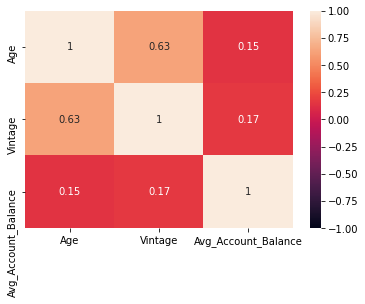

In [99]:
sns.heatmap(X[['Age','Vintage', 'Avg_Account_Balance']].corr(), vmin=-1, vmax=1, annot=True)

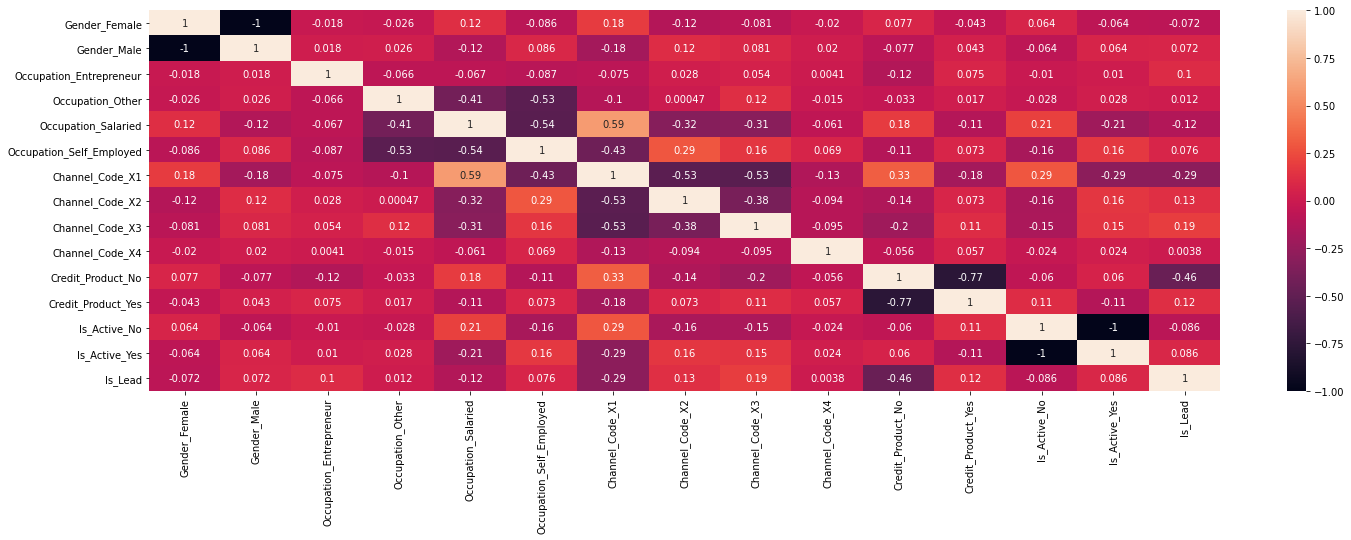

In [63]:
plt.figure(figsize=[24,7])
corr_df = X[['Gender_Female', 'Gender_Male', 'Occupation_Entrepreneur',
              'Occupation_Other', 'Occupation_Salaried', 'Occupation_Self_Employed',
              'Channel_Code_X1', 'Channel_Code_X2', 'Channel_Code_X3',
              'Channel_Code_X4', 'Credit_Product_No', 'Credit_Product_Yes',
              'Is_Active_No', 'Is_Active_Yes' ]]
corr_df['Is_Lead']  = y
sns.heatmap(corr_df.corr(), vmin=-1, vmax=1, annot=True)

In [64]:
def min_max_scaler(variable_to):
  min_var = variable_to.min()
  max_var = variable_to.max()
  denom = float(max_var) - float(min_var)
  y = (variable_to - min_var)/denom
  return y

In [6]:
df_ads_v2 = df_ads[:]
df_ads_v2 = df_ads_v2.replace({'Female': 1, 'Male': 0})
df_region = df_ads_v2.groupby(['Region_Code'], as_index = False).agg({'Gender':'sum', 'ID':'count', 'Age':'mean', 'Avg_Account_Balance':'mean',
                                                          'Vintage': 'mean'})
df_region.columns = ['Region_Code','Region_Code_total_female','Region_Code_total_sum','Region_Code_AvgAge','Region_Code_avg_account_bal','Region_Code_avg_vintage']

def add_feature(group):
  group['Region_Code_total_entrepreneur'] = len(group[group.Occupation == 'Entrepreneur'])
  group['Region_Code_total_Salaried'] = len(group[group.Occupation == 'Salaried'])
  group['Region_Code_total_Self_Employed'] = len(group[group.Occupation == 'Self_Employed'])
  group['Region_Code_total_Other'] = len(group[group.Occupation == 'Other'])
  return group

df_region_2 = df_ads_v2.groupby(['Region_Code'], as_index = False).apply(add_feature)

df_ads_v2 = pd.merge(df_region_2, df_region, on = ['Region_Code'], how = 'left')

df_occupation = df_ads_v2.groupby(['Occupation'], as_index = False).agg({'ID':'count','Gender':'sum', 'Age':'mean', 'Avg_Account_Balance':'mean','Vintage': 'mean'})
df_occupation.columns = ['Occupation','Occupation_count','Occupation_total_female','Occupation_age','Occupation_avg_account_balance','Occupation_Vintage']
 
 
df_ads_v2 = pd.merge(df_ads_v2, df_occupation, on = ['Occupation'], how = 'left')

df_Channel_Code = df_ads_v2.groupby(['Channel_Code'], as_index = False).agg({'ID':'count','Gender':'sum', 'Age':'mean', 'Avg_Account_Balance':'mean','Vintage': 'mean'})
df_Channel_Code.columns = ['Channel_Code','Channel_Code_count','Channel_Code_total_female','Channel_Code_age','Channel_Code_avg_account_balance','Channel_Code_Vintage']

df_ads_v2 = pd.merge(df_ads_v2, df_Channel_Code, on = ['Channel_Code'], how = 'left')
df_ads_v2.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead', 'Region_Code_total_entrepreneur',
       'Region_Code_total_Salaried', 'Region_Code_total_Self_Employed',
       'Region_Code_total_Other', 'Region_Code_total_female',
       'Region_Code_total_sum', 'Region_Code_AvgAge',
       'Region_Code_avg_account_bal', 'Region_Code_avg_vintage',
       'Occupation_count', 'Occupation_total_female', 'Occupation_age',
       'Occupation_avg_account_balance', 'Occupation_Vintage',
       'Channel_Code_count', 'Channel_Code_total_female', 'Channel_Code_age',
       'Channel_Code_avg_account_balance', 'Channel_Code_Vintage'],
      dtype='object')

In [39]:
##Splitting the data into train and test for training of the model
X = df_ads_v2[[ 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Region_Code_total_entrepreneur',
       'Region_Code_total_Salaried', 'Region_Code_total_Self_Employed',
       'Region_Code_total_Other', 'Region_Code_total_female',
       'Region_Code_total_sum', 'Region_Code_AvgAge',
       'Region_Code_avg_account_bal', 'Region_Code_avg_vintage',
       'Occupation_count', 'Occupation_total_female', 'Occupation_age',
       'Occupation_avg_account_balance', 'Occupation_Vintage',
       'Channel_Code_count', 'Channel_Code_total_female', 'Channel_Code_age',
       'Channel_Code_avg_account_balance', 'Channel_Code_Vintage']]

X = pd.get_dummies(X)         

y = df_ads_v2['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
## Training the model
rs_RF_opt_v1 = RandomForestClassifier(bootstrap=True,max_features = 10, max_depth=12, n_estimators=150,  random_state=0,n_jobs =-1)
rs_RF_opt_v1.fit(X_train, y_train)

## AUC_ROC_SCORE
y_pred_RF = rs_RF_opt_v1.predict_proba(X_test.values)
auc_RF_fe = roc_auc_score(y_test, y_pred_RF[:,1])
print(auc_RF_fe)

0.8691899167755692


### Light GBM

In [70]:
params={'lambda': 3, 
        'alpha': 0.001, 
        'colsample_bytree': 0.5, 
        'subsample': 0.4, 
        'learning_rate': 0.3, 
        'max_depth': 13, 
        'random_state': 24,
        'min_child_weight': 5}
err = [] 

oob = np.zeros(shape=(len(X)))
preds_lgbm = np.zeros(shape=(len(df_testv1)))

Folds=8
fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    m = LGBMClassifier(n_estimators=1000,**params,verbose= -1)

    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=30,verbose=False,eval_metric='auc')

    pred_y = m.predict_proba(x_val)[:,1]
    oofs[test_index] = pred_y
    print(i, " roc_auc_Score: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    preds_lgbm+= m.predict_proba(df_testv1)[:,1]
    i = i + 1
preds_lgbm = preds_lgbm/Folds
print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = roc_auc_score(y, oofs)
print(f'\nOut of Bag Auc is : {oof_score}')

preds_lgbm=pd.DataFrame(preds_lgbm,columns=['Is_Lead'])

# oofs.to_csv('lgbmoof.csv',index=False)
# preds.to_csv('lgbmpred.csv',index=False)

1  roc_auc_Score:  0.8738408917809504
2  roc_auc_Score:  0.8736182406076047
3  roc_auc_Score:  0.8723846790639946
4  roc_auc_Score:  0.8725521375367888
5  roc_auc_Score:  0.877344480126586
6  roc_auc_Score:  0.8743079924210662
7  roc_auc_Score:  0.8734289487607692
8  roc_auc_Score:  0.874174067375484
Average StratifiedKFold Score : 0.8739564297091555 

Out of Bag Auc is : 0.8738314469214772


In [77]:
 params={'lambda': 1.5, 
        'alpha': 0.4, 
        'colsample_bytree': 0.7, 
        'subsample': 0.8, 
        'learning_rate': 0.3,
        'max_depth': 9, 
        'random_state': 20, 
        'min_child_weight': 30}

preds_xgb = np.zeros(shape=(len(df_testv1)))   
err = [] 

oofs = np.zeros(shape=(len(X)))

Folds=8

fold = StratifiedKFold(n_splits=Folds, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    m = XGBClassifier(n_estimators=600,**params)

    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=30,verbose=False,eval_metric='auc')

    pred_y = m.predict_proba(x_val)[:,1]
    oofs[test_index] = pred_y
    print(i, " roc_auc_score: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    preds_xgb+= m.predict_proba(df_testv1)[:,1]
    i = i + 1

preds_xgb = preds_xgb/Folds
print(f"Average StratifiedKFold Score : {sum(err)/Folds} ")
oof_score = roc_auc_score(y, oofs)
print(f'\nOut of bag Auc is : {oof_score}')
    
preds_xgb=pd.DataFrame(preds_xgb,columns=['Is_Lead'])


1  roc_auc_score:  0.8731190811510776
2  roc_auc_score:  0.8739199698812579
3  roc_auc_score:  0.8726339161077981
4  roc_auc_score:  0.871873557869564
5  roc_auc_score:  0.8764888263191976
6  roc_auc_score:  0.8742232139393539
7  roc_auc_score:  0.8728013407841075
8  roc_auc_score:  0.8735108714167603
Average StratifiedKFold Score : 0.8735713471836396 

Out of bag Auc is : 0.8675863748834304


In [82]:
y_pred = (preds_xgb + preds_lgbm)/2

In [86]:
y_pred = y_pred
df_submission = df_test[['ID']]
df_submission['Is_Lead'] = y_pred
df_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission_lgbm_xgb_ensemble.csv", index=False)

## Summary of models

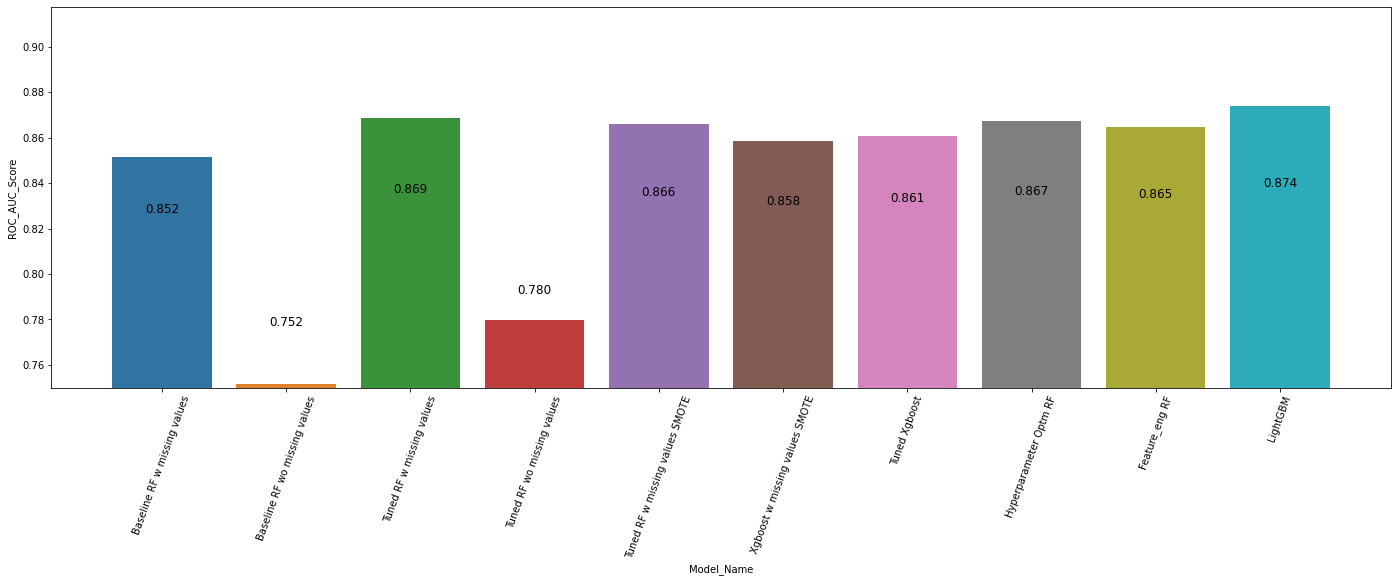

In [67]:
df_result = pd.DataFrame(columns=['Model_Name','ROC_AUC_Score'])
df_result['Model_Name'] = ['Baseline RF w missing values','Baseline RF wo missing values',
                           'Tuned RF w missing values', 'Tuned RF wo missing values',
                           'Tuned RF w missing values SMOTE', 'Xgboost w missing values SMOTE',
                           'Tuned Xgboost', 'Hyperparameter Optm RF', 'Feature_eng RF', 'LightGBM']
df_result['ROC_AUC_Score'] = [auc_baseline_w_missing, auc_baseline_wo_missing,
                              auc_tune_RF, auc_tune_RF_wo_missing,
                              auc_smote, auc_xgbsmote, auc_xgb, auc_RF, auc_RF_opt,
                              oof_score]
plt.figure(figsize=[24,7])                              
sns.barplot( df_result['Model_Name'], df_result['ROC_AUC_Score']) 
plt.ylim(0.75,)
# Get current axis on current figure
ax = plt.gca()
plt.xticks(rotation = 'vertical')

# Or use degrees explicitly 

degrees = 70  # Adjust according to one's preferences/needs
plt.xticks(rotation=degrees)
# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., 0.5*(p.get_height() + 0.8) , '%.3f' % float(p.get_height()), 
            fontsize=12, color='black', ha='center', va='bottom')
plt.plot()
plt.show()                             

## Prediction

In [16]:
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test_mSzZ8RL.csv")
df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [73]:
df_test.shape

(105312, 10)

In [74]:
df_sub = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sample_submission_eyYijxG.csv")
df_sub.head()

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,0
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0


In [98]:
df_test_v1 = pd.get_dummies(df_test[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']])

### Displaying the best model

In [68]:
print("Top models are")
df_result = df_result.sort_values(by=['ROC_AUC_Score'], ascending= False).reset_index(drop = True)
df_result[:3]

Top models are


,Model_Name,ROC_AUC_Score
0,LightGBM,0.873831
1,Tuned RF w missing values,0.868697
2,Hyperparameter Optm RF,0.867300


In [80]:
y_pred = Tuned_RF.predict_proba(df_test_v1)
df_submission = df_test[['ID']]
df_submission['Is_Lead'] = y_pred[:,1]
df_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission_RF_final.csv", index=False)

### Re Training of the top 3 models with 100% data

In [60]:
##Feature engineering for LGBM
df_region = df_ads_v2[['Region_Code','Region_Code_total_entrepreneur',
                        'Region_Code_total_Salaried', 'Region_Code_total_Self_Employed',
                       'Region_Code_total_Other', 'Region_Code_total_female','Region_Code_total_sum', 'Region_Code_AvgAge',
                       'Region_Code_avg_account_bal', 'Region_Code_avg_vintage']].drop_duplicates()
df_testv1 = pd.merge(df_test, df_region, on = ['Region_Code'], how = 'left')
df_testv1 = pd.merge(df_testv1, df_occupation, on = ['Occupation'], how = 'left')
df_testv1 = pd.merge(df_testv1, df_Channel_Code, on = ['Channel_Code'], how = 'left')

df_testv1 = df_testv1[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Region_Code_total_entrepreneur',
       'Region_Code_total_Salaried', 'Region_Code_total_Self_Employed',
       'Region_Code_total_Other', 'Region_Code_total_female',
       'Region_Code_total_sum', 'Region_Code_AvgAge',
       'Region_Code_avg_account_bal', 'Region_Code_avg_vintage',
       'Occupation_count', 'Occupation_total_female', 'Occupation_age',
       'Occupation_avg_account_balance', 'Occupation_Vintage',
       'Channel_Code_count', 'Channel_Code_total_female', 'Channel_Code_age',
       'Channel_Code_avg_account_balance', 'Channel_Code_Vintage']]
df_testv1 = df_testv1.replace({'Female': 1, 'Male': 0})
df_testv1 = pd.get_dummies(df_testv1)  

## LGBM
df_submission = df_test[['ID']]
df_submission['Is_Lead'] = preds_lgbm['Is_Lead']
df_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission_LGBM.csv", index=False)

#### Re training of first champion model

In [99]:
X = df_ads[['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
                'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active']]
X = pd.get_dummies(X)           
y = df_ads['Is_Lead']

#### Re training of first challenger model

In [100]:
Tuned_RF_re = RandomForestClassifier(max_depth=12, n_estimators=150,  random_state=0, n_jobs =-1)
Tuned_RF_re.fit(X, y)

y_pred = Tuned_RF_re.predict_proba(df_test_v1)
df_submission = df_test[['ID']]
df_submission['Is_Lead'] = y_pred[:,1]
df_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission_RF_tuned_re.csv", index=False)

#### Re training of Second challenger model

In [102]:
Tuned_rs_RF = RandomForestClassifier(criterion= 'gini', max_depth= 80, max_features= 3, min_samples_leaf= 4, min_samples_split= 10, n_estimators= 1000, random_state=42)
Tuned_rs_RF.fit(X, y)

y_pred = Tuned_rs_RF.predict_proba(df_test_v1)
df_submission = df_test[['ID']]
df_submission['Is_Lead'] = y_pred[:,1]
df_submission.to_csv("/content/drive/MyDrive/Colab Notebooks/submission_RF_rs_re.csv", index=False)